In [1]:
import os
import sys
import torch
import numpy as np

from Datasets.Datasets_Functions import *
from Visualization import Visualization

from Related_Codes.DECAutoencoder import DECAutoencoder, DECCDAutoencoder
from General_Functions import General_Functions

In [2]:
path_to_module = './'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
 

In [3]:
hashmap_path = path_to_module + 'Datasets/'
hashmap = get_hashmap(hashmap_path)
print(hashmap)
dataset_name = "r100"
dataset_properties = hashmap[dataset_name]
batch_size = dataset_properties['batch_size'] = 256
#n_clusters = dataset_properties['n_clusters'] = 2
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, dataset_properties)
print(input_dim)

{'tcga': {'batch_size': 256, 'n_clusters': 5, 'module_name': 'Datasets.Datasets'}, 'emnist_balanced_letters': {'batch_size': 256, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}, 'emnist_mnist': {'batch_size': 1024, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}, 'emnist_balanced_digits': {'batch_size': 256, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}, 'dermatology': {'batch_size': 64, 'n_clusters': 6, 'module_name': 'Datasets.Datasets'}, 'ecoil': {'batch_size': 64, 'n_clusters': 8, 'module_name': 'Datasets.Datasets'}, 'iris': {'batch_size': 64, 'n_clusters': 3, 'module_name': 'Datasets.Datasets'}, 'rings': {'batch_size': 64, 'n_clusters': 2, 'module_name': 'Datasets.Datasets'}, 'wine': {'batch_size': 64, 'n_clusters': 3, 'module_name': 'Datasets.Datasets'}, 'australian': {'batch_size': 64, 'n_clusters': 2, 'module_name': 'Datasets.Datasets'}, 'moons': {'batch_size': 64, 'n_clusters': 2, 'module_name': 'Datasets.Datasets'}, 'squeezed_gauss': {'batch_size': 64, 'n

[nltk_data] Downloading package punkt to C:\Users\PAPASOFT
[nltk_data]     INC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\PAPASOFT
[nltk_data]     INC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100


In [4]:
visualization = Visualization()

### Dec

In [5]:
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 5e-4

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 5e-4
alpha = 1.0
momentum = 0.9
latent_dim = 2
n_channels = 1
negative_slope = 0
is_MLP_AE = True

if(is_MLP_AE):
    dec_autoencoder = DECAutoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
else:  
    input_dim = 1
    dec_autoencoder = DECCDAutoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels) 
dec_autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
dec_autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
dec_autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, momentum=momentum, alpha=alpha )
dec_autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
dec_autoencoder.set_path()
dec_autoencoder = dec_autoencoder.to(device)

pretrain = True
if(pretrain):
    dec_autoencoder.pretrain_autoencoder()
    dec_autoencoder.save_pretrained_weights()
else:
    model_save_path = dec_autoencoder.data_dir_path + '/Weigths/autoencoder_weights.pth'
    dec_autoencoder.load_state_dict(torch.load(model_save_path))

Epoch: 0, Loss: 4.862223
Epoch: 1, Loss: 2.730259
Epoch: 2, Loss: 2.045775
Epoch: 3, Loss: 1.482761
Epoch: 4, Loss: 1.493006
Epoch: 5, Loss: 1.373297
Epoch: 6, Loss: 1.319398
Epoch: 7, Loss: 1.153033
Epoch: 8, Loss: 1.307396
Epoch: 9, Loss: 1.020199
Epoch: 10, Loss: 0.858701
Epoch: 11, Loss: 0.999496
Epoch: 12, Loss: 0.802208
Epoch: 13, Loss: 0.722567
Epoch: 14, Loss: 0.656848
Epoch: 15, Loss: 0.607352
Epoch: 16, Loss: 0.537202
Epoch: 17, Loss: 0.608929
Epoch: 18, Loss: 0.694076
Epoch: 19, Loss: 0.523120
Epoch: 20, Loss: 0.401574
Epoch: 21, Loss: 0.631149
Epoch: 22, Loss: 0.459760
Epoch: 23, Loss: 0.573793
Epoch: 24, Loss: 0.484664
Epoch: 25, Loss: 0.436461
Epoch: 26, Loss: 0.466231
Epoch: 27, Loss: 0.360079
Epoch: 28, Loss: 0.325808
Epoch: 29, Loss: 0.297096
Epoch: 30, Loss: 0.283179
Epoch: 31, Loss: 0.328853
Epoch: 32, Loss: 0.354558
Epoch: 33, Loss: 0.718596
Epoch: 34, Loss: 0.431049
Epoch: 35, Loss: 0.290398
Epoch: 36, Loss: 0.302831
Epoch: 37, Loss: 0.220673
Epoch: 38, Loss: 0.300

In [6]:
dec_autoencoder.kmeans_initialization()
dec_autoencoder.train_autoencoder()
cluster_centers = dec_autoencoder.get_cluster_centers()
_, dec_autoencoder_reduced_data, labels = dec_autoencoder.get_latent_data()
General_Functions().save_excel(dec_autoencoder.data_dir_path, dec_autoencoder.df_eval)

ACC: 0.77 PUR: 0.77 NMI: 0.70 ARI: 0.58


C:\Users\PAPASOFT INC\AppData\Roaming\Python\Python310\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Ep: 0 Rec L: 0.0768 L: 5.9879 ACC: 0.83 PUR: 0.83 NMI: 0.73 ARI: 0.66
Ep: 1 Rec L: 0.1508 L: 6.3015 ACC: 0.86 PUR: 0.86 NMI: 0.74 ARI: 0.69
Ep: 2 Rec L: 0.2043 L: 6.3822 ACC: 0.88 PUR: 0.88 NMI: 0.75 ARI: 0.71
Ep: 3 Rec L: 0.2329 L: 6.5069 ACC: 0.88 PUR: 0.88 NMI: 0.76 ARI: 0.72
Ep: 4 Rec L: 0.2462 L: 6.6141 ACC: 0.89 PUR: 0.89 NMI: 0.77 ARI: 0.73
Ep: 5 Rec L: 0.2725 L: 6.6808 ACC: 0.89 PUR: 0.89 NMI: 0.79 ARI: 0.75
Ep: 6 Rec L: 0.2860 L: 6.7506 ACC: 0.90 PUR: 0.90 NMI: 0.80 ARI: 0.77
Ep: 7 Rec L: 0.3006 L: 6.8000 ACC: 0.91 PUR: 0.91 NMI: 0.81 ARI: 0.78
Ep: 8 Rec L: 0.3106 L: 6.8217 ACC: 0.91 PUR: 0.91 NMI: 0.82 ARI: 0.79
Ep: 9 Rec L: 0.3177 L: 6.8887 ACC: 0.92 PUR: 0.92 NMI: 0.83 ARI: 0.80
Ep: 10 Rec L: 0.3240 L: 6.9291 ACC: 0.92 PUR: 0.92 NMI: 0.83 ARI: 0.81
Ep: 11 Rec L: 0.3362 L: 6.9387 ACC: 0.92 PUR: 0.92 NMI: 0.84 ARI: 0.82
Ep: 12 Rec L: 0.3510 L: 6.9470 ACC: 0.92 PUR: 0.92 NMI: 0.84 ARI: 0.82
Ep: 13 Rec L: 0.3385 L: 6.9786 ACC: 0.93 PUR: 0.93 NMI: 0.84 ARI: 0.82
Ep: 14 Rec L: 0.

C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:23: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = workbook
C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:27: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Directory './Results/r100/DECAE/100_Eps_ld_2_out_4_bs_256_lr_0.0005_momentum_0.9_alpha_1.0/Experiments/No_TSNE' already exists.


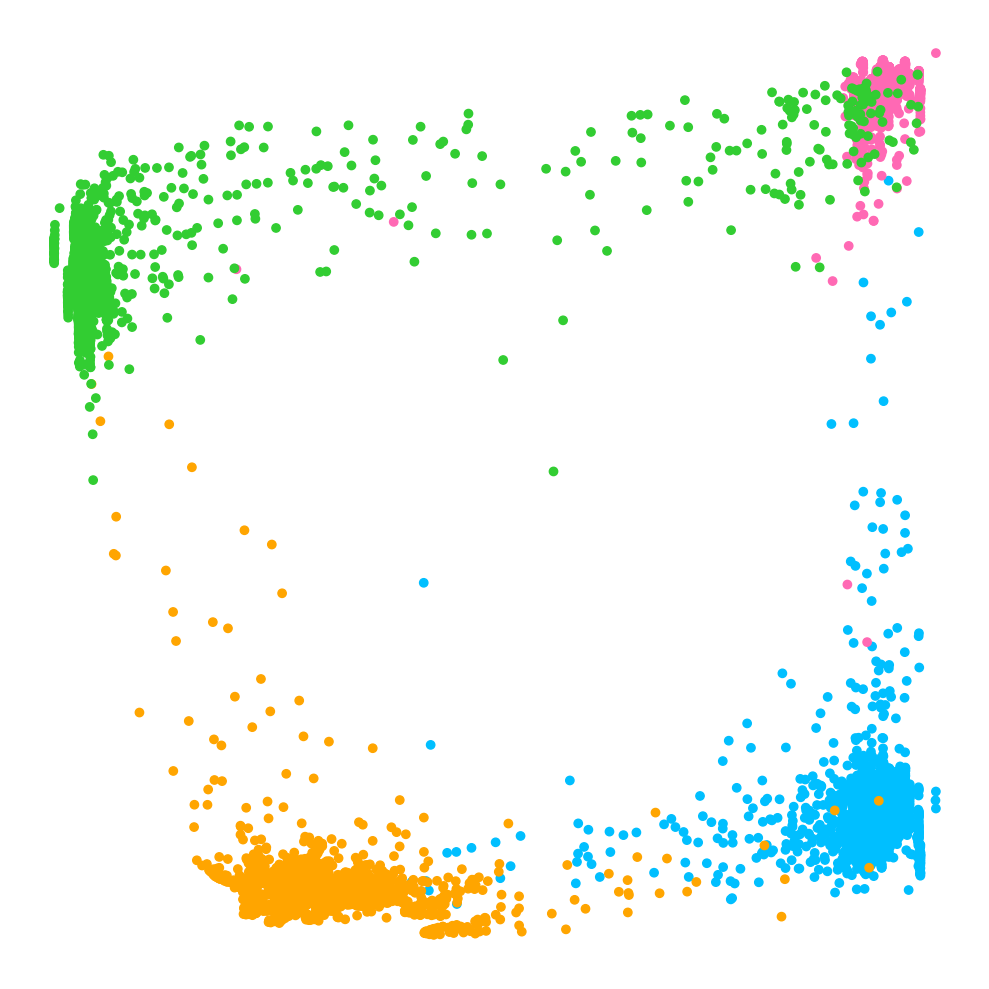

In [7]:
visualization.plot(dec_autoencoder_reduced_data, labels, labels, cluster_centers, dec_autoencoder.data_dir_path)